In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-15 15:51:44.056863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744721504.077319   37037 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744721504.082871   37037 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744721504.101315   37037 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744721504.101338   37037 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744721504.101341   37037 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
precision_15000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/15000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/15000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        precision_15000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(precision_15000).transpose().to_dict()
    print()
    with open('results_15000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_15000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_15000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_15000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [6]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [7]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
118059,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
118060,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
118061,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
118062,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
118063,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [10]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
118059    Bruteforce
118060    Bruteforce
118061    Bruteforce
118062    Bruteforce
118063    Bruteforce
Name: Attack Type, Length: 118064, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100354, 46), (100354,), (17710, 46), (17710,))

# K Nearest Neighbour

In [16]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 12.5 s, sys: 27.2 ms, total: 12.6 s
Wall time: 3.68 s


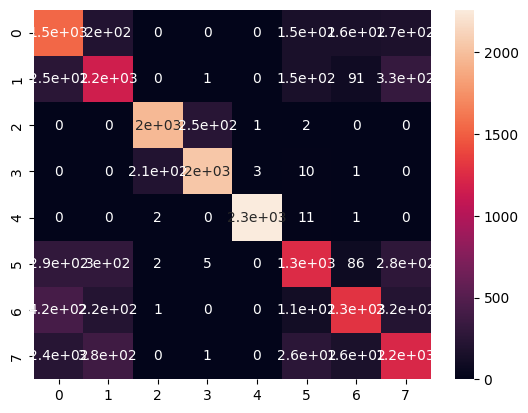

In [17]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [18]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [19]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [20]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [21]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.720045,0.726448,0.720738,0.720045,0.680853,1.057595,5.40847,2.325612,3.676489


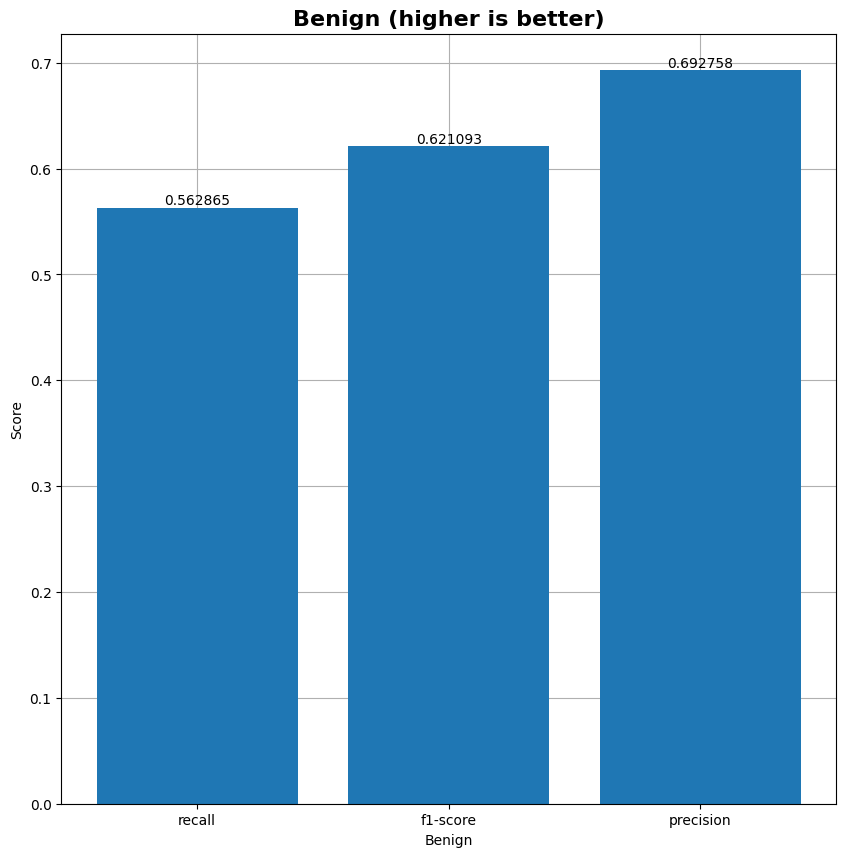

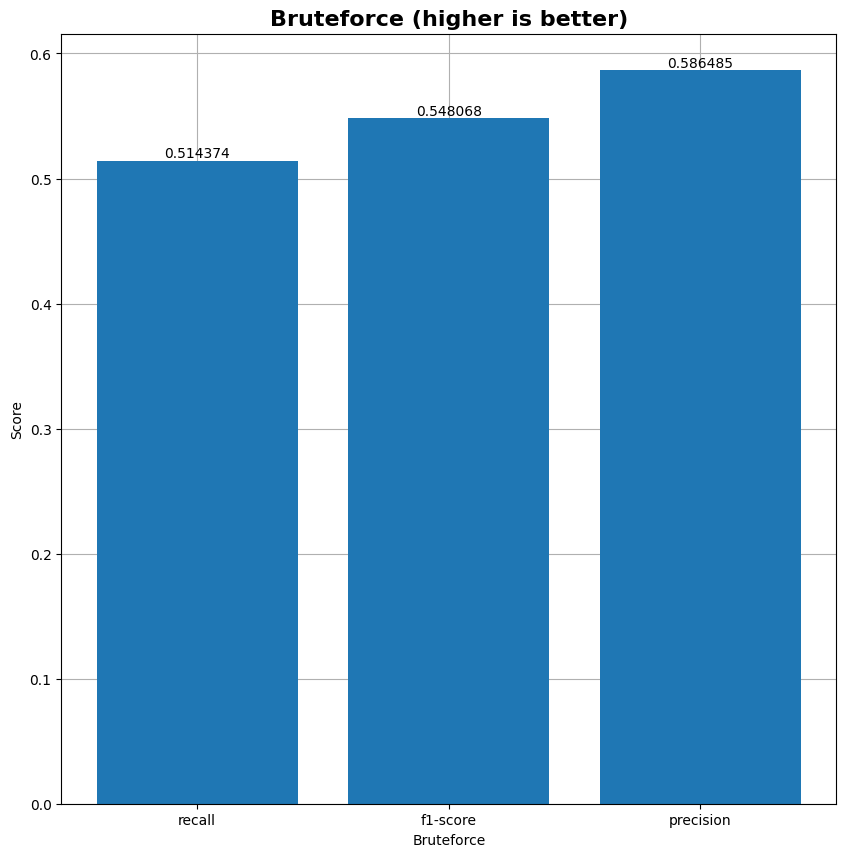

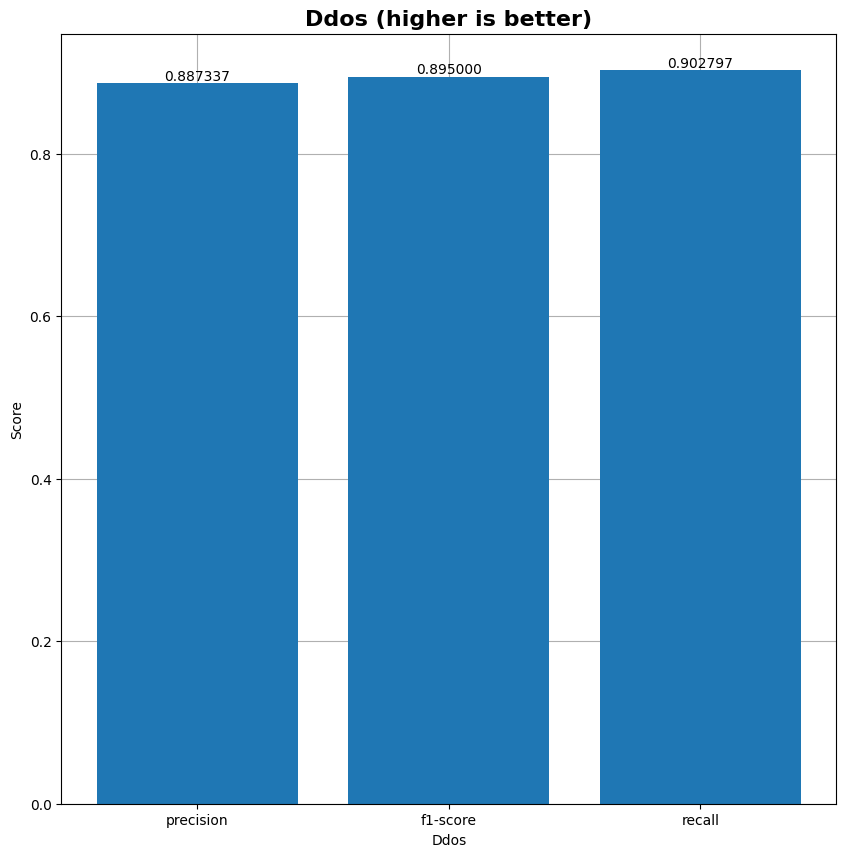

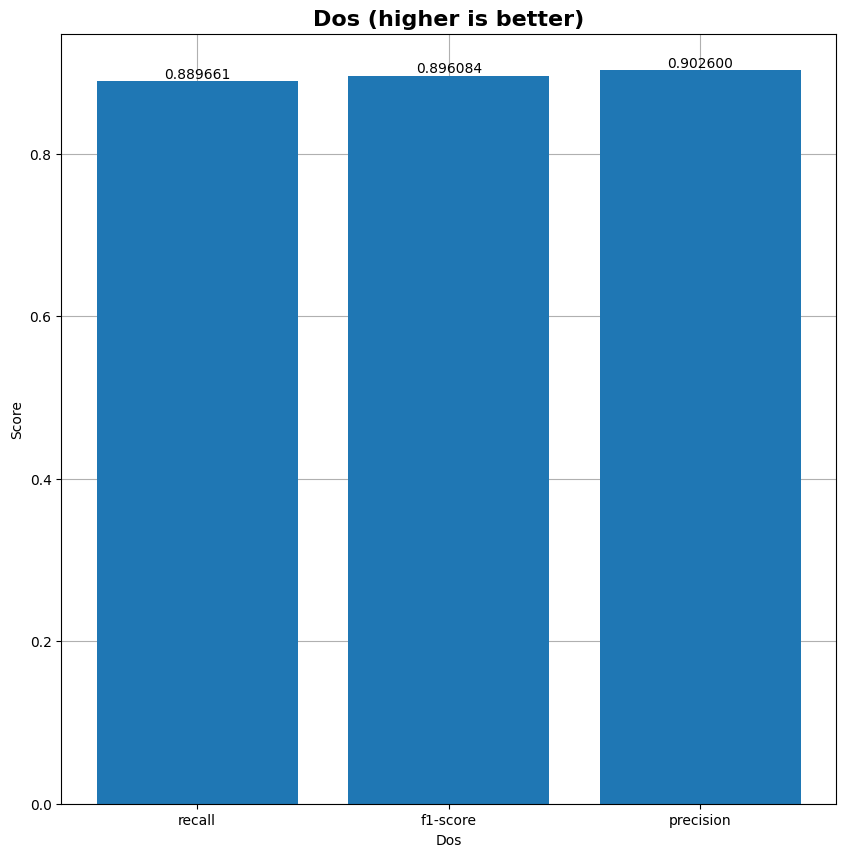

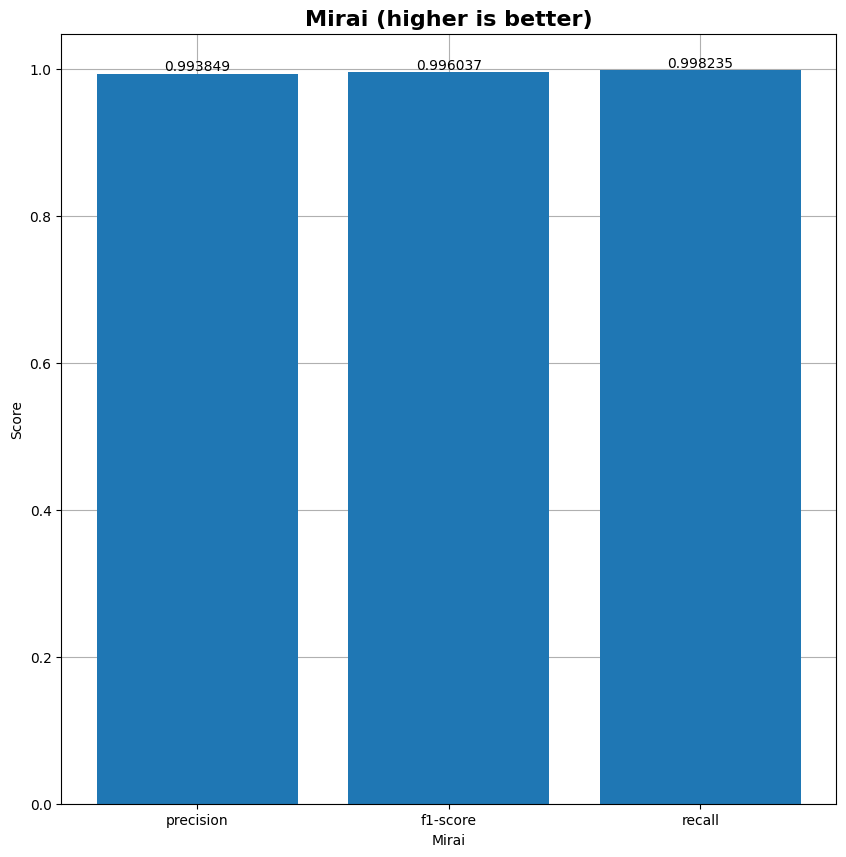

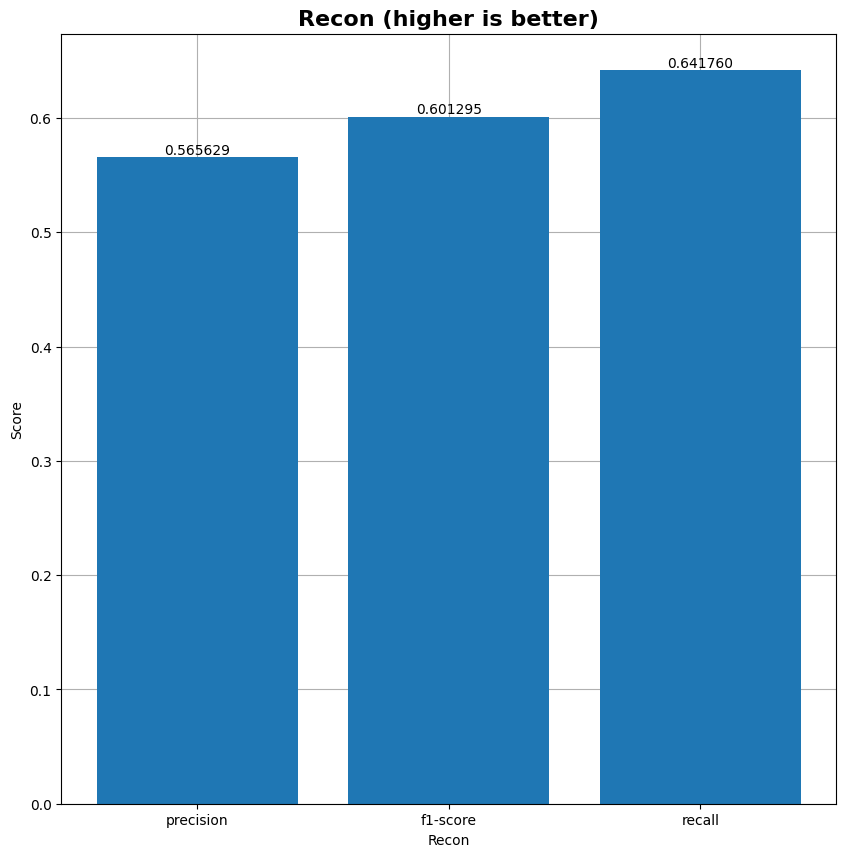

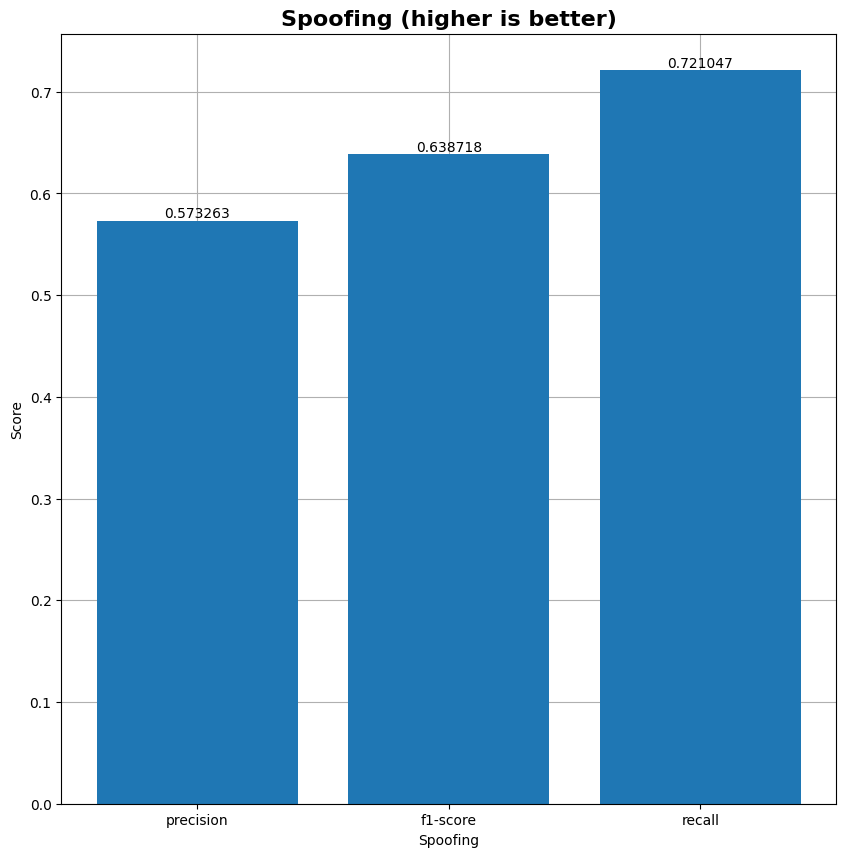

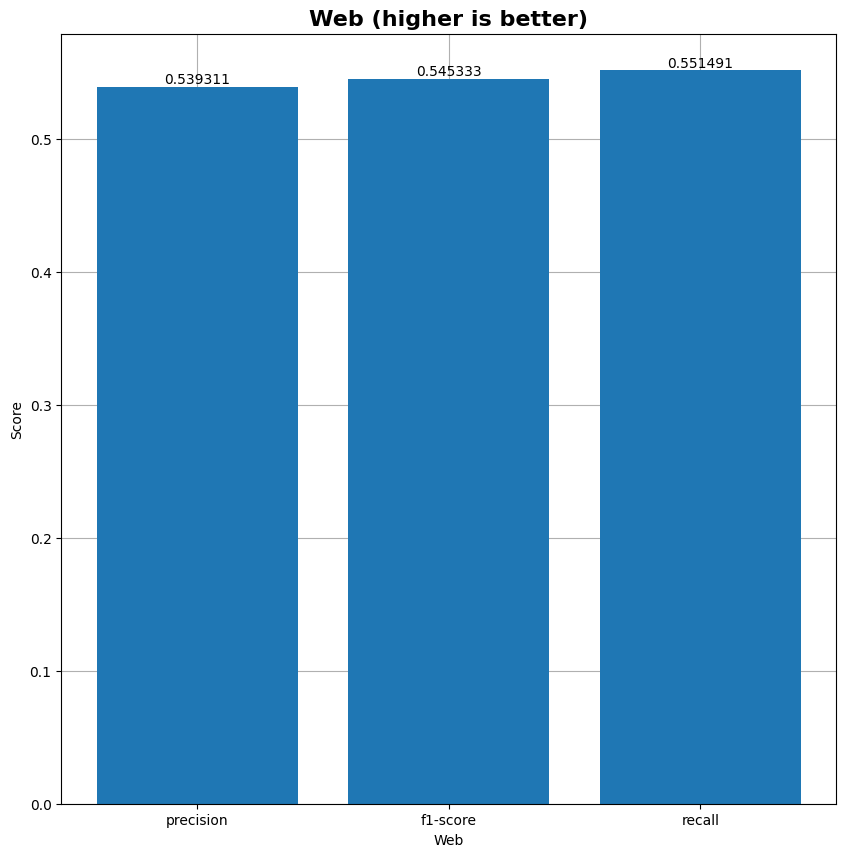

In [22]:
plot_mc(y_pred, y_test, "kNN")

In [23]:
model_name = "kNN_15000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Logistic Regression

In [24]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

CPU times: user 8min 37s, sys: 555 ms, total: 8min 38s
Wall time: 8min 40s


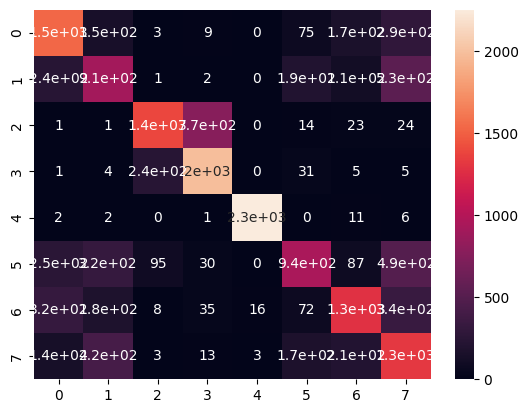

In [25]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [26]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [27]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LR_time]
results_dict["LR"] = results

In [28]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [29]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.720045,0.726448,0.720738,0.720045,0.680853,1.057595,5.408470,2.325612,3.676489
LR,0.655618,0.667443,0.654224,0.655618,0.608307,1.197572,5.894692,2.427899,520.183744


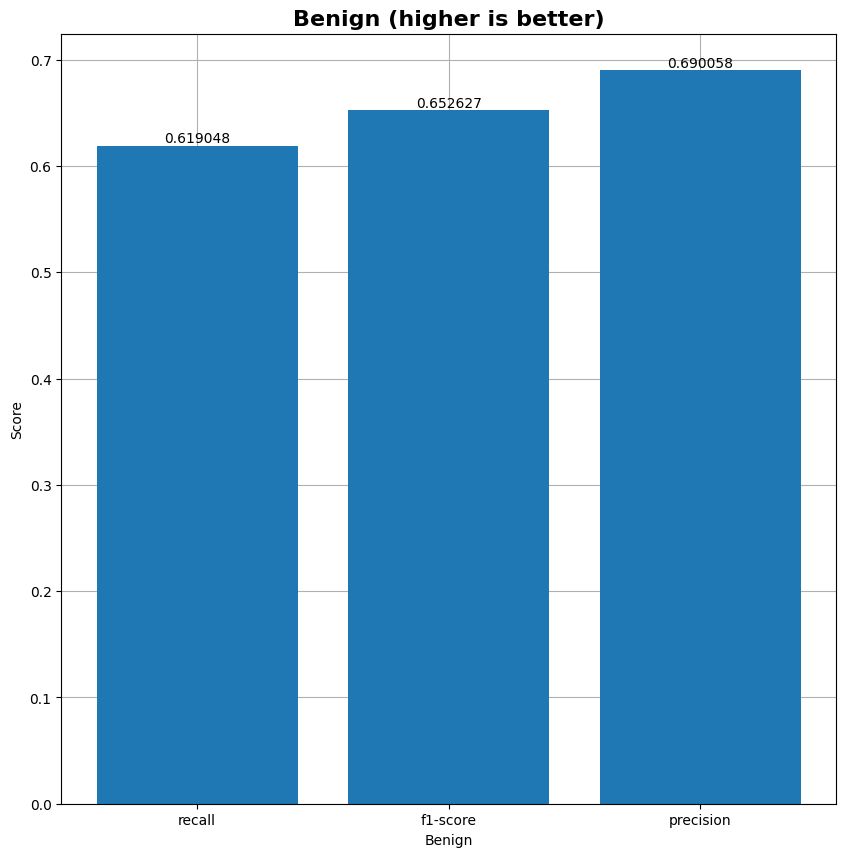

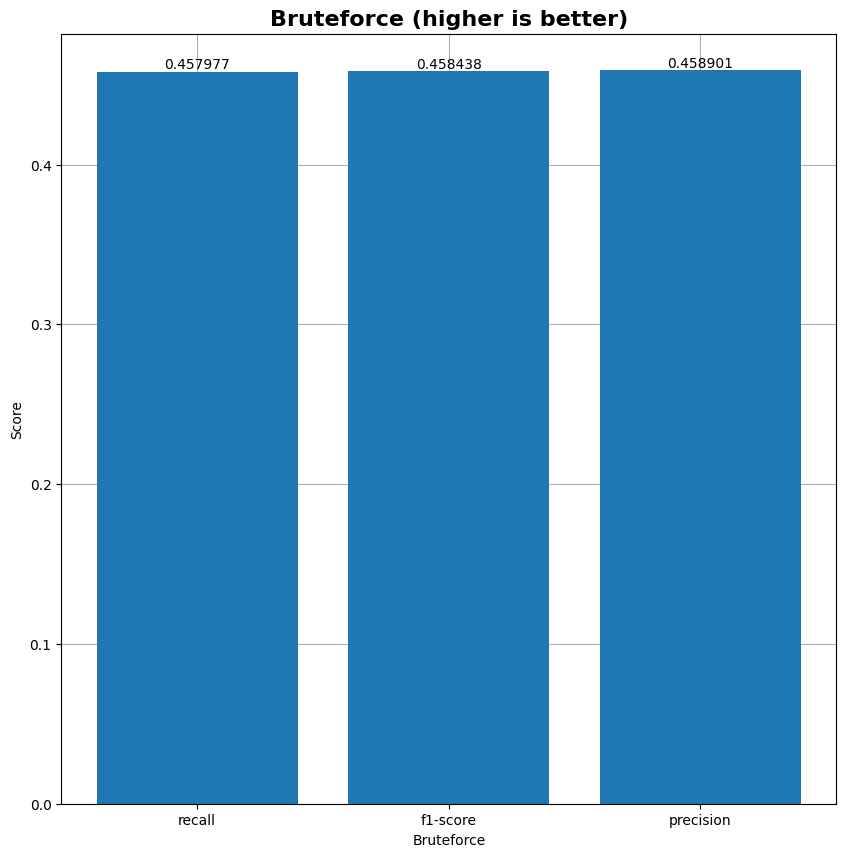

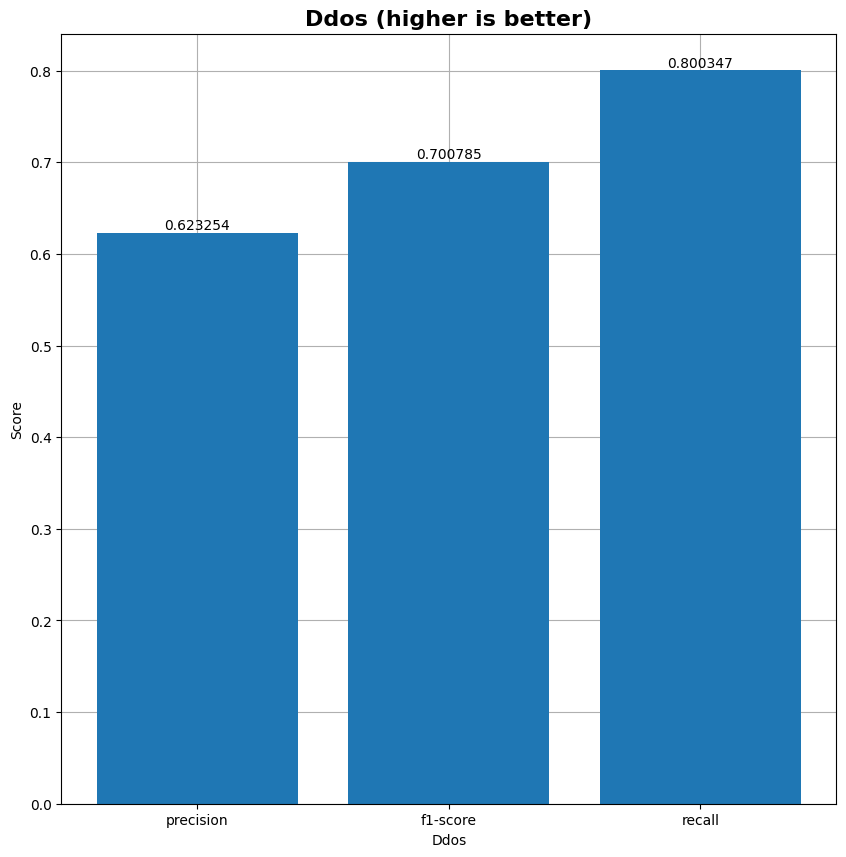

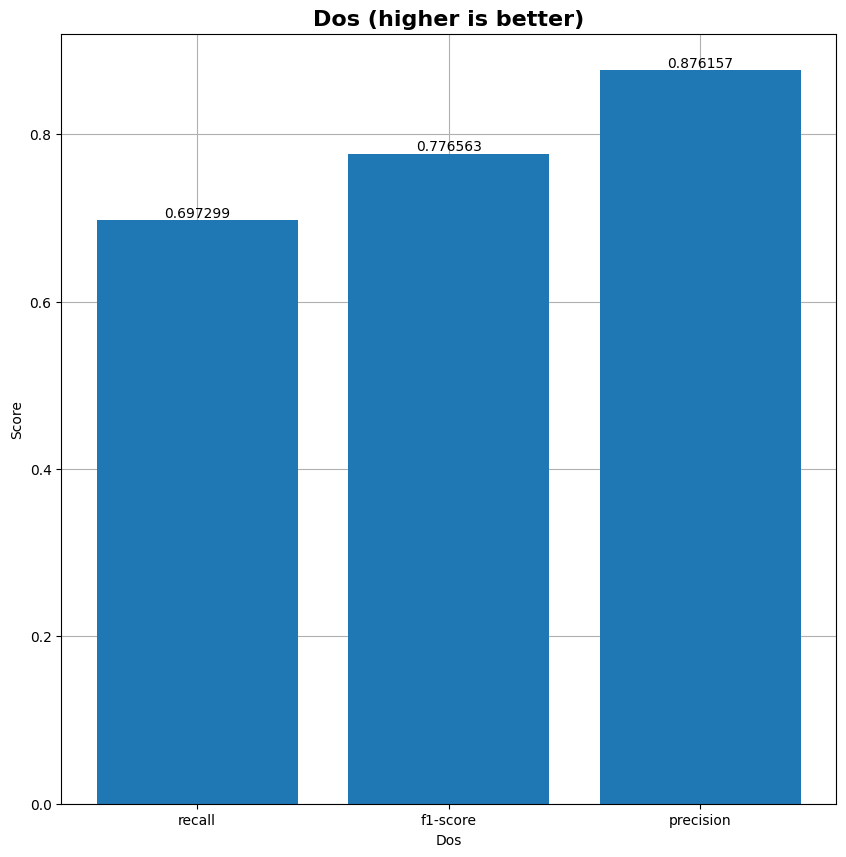

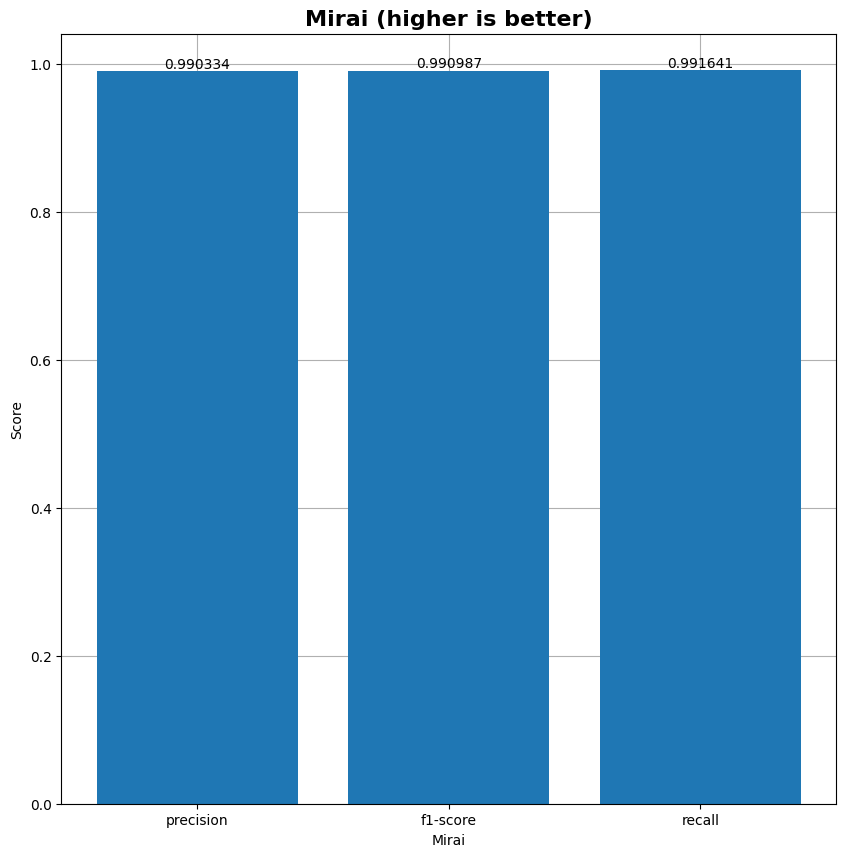

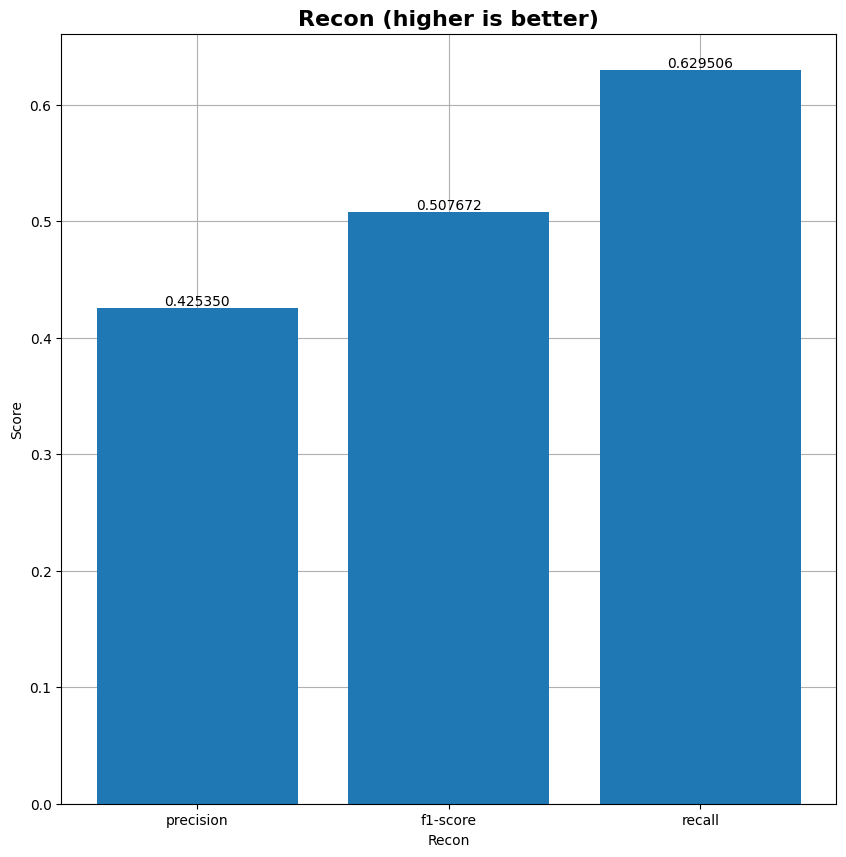

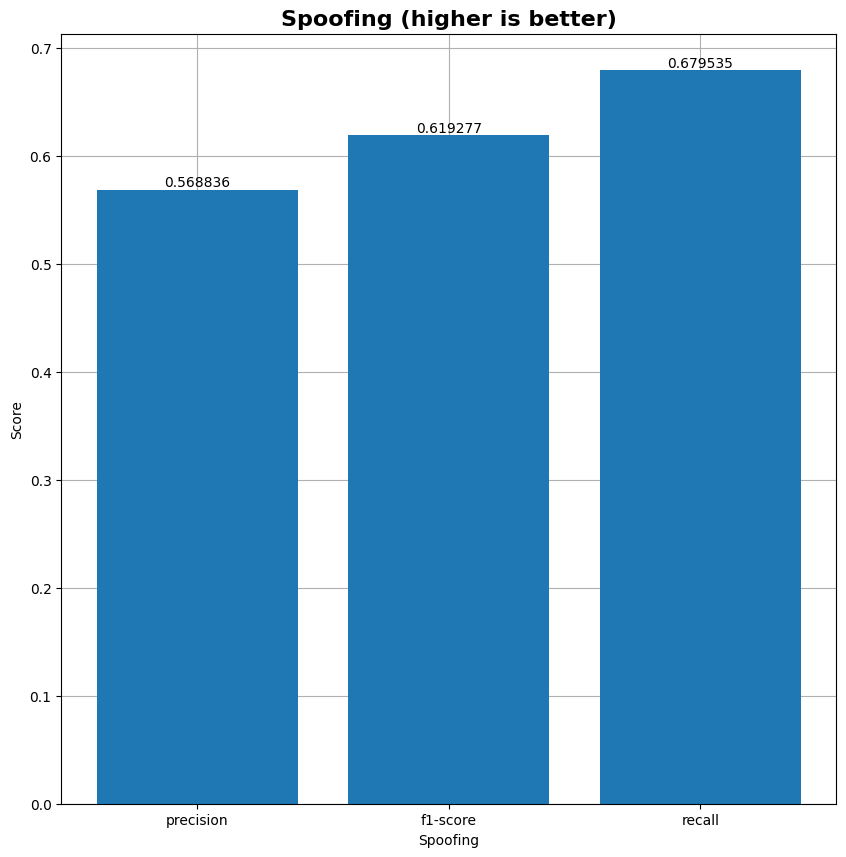

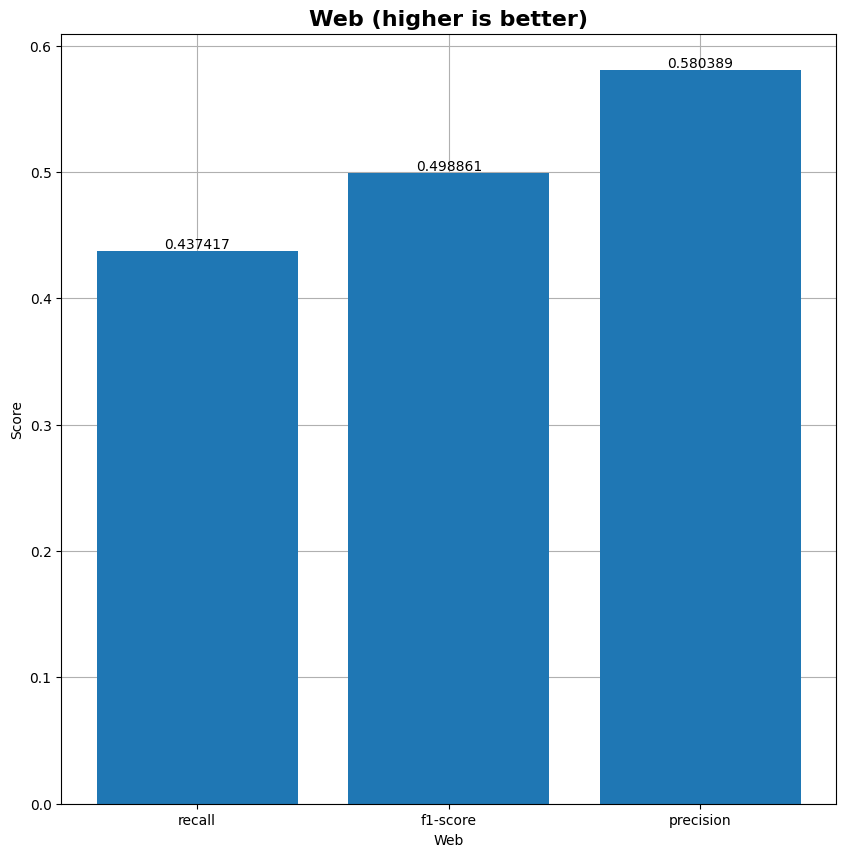

In [30]:
plot_mc(y_pred, y_test, "LR")

In [31]:
model_name = "LR_15000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [32]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 40.9 s, sys: 255 ms, total: 41.1 s
Wall time: 5.65 s


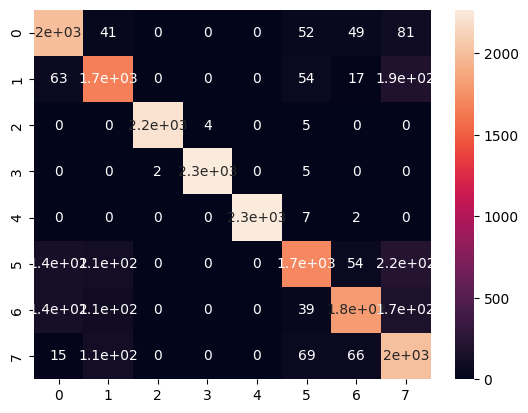

In [33]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [34]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [35]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [36]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [37]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.720045,0.726448,0.720738,0.720045,0.680853,1.057595,5.408470,2.325612,3.676489
LR,0.655618,0.667443,0.654224,0.655618,0.608307,1.197572,5.894692,2.427899,520.183744
RF,0.898532,0.902276,0.898715,0.898532,0.884540,0.385263,1.927442,1.388323,5.650334


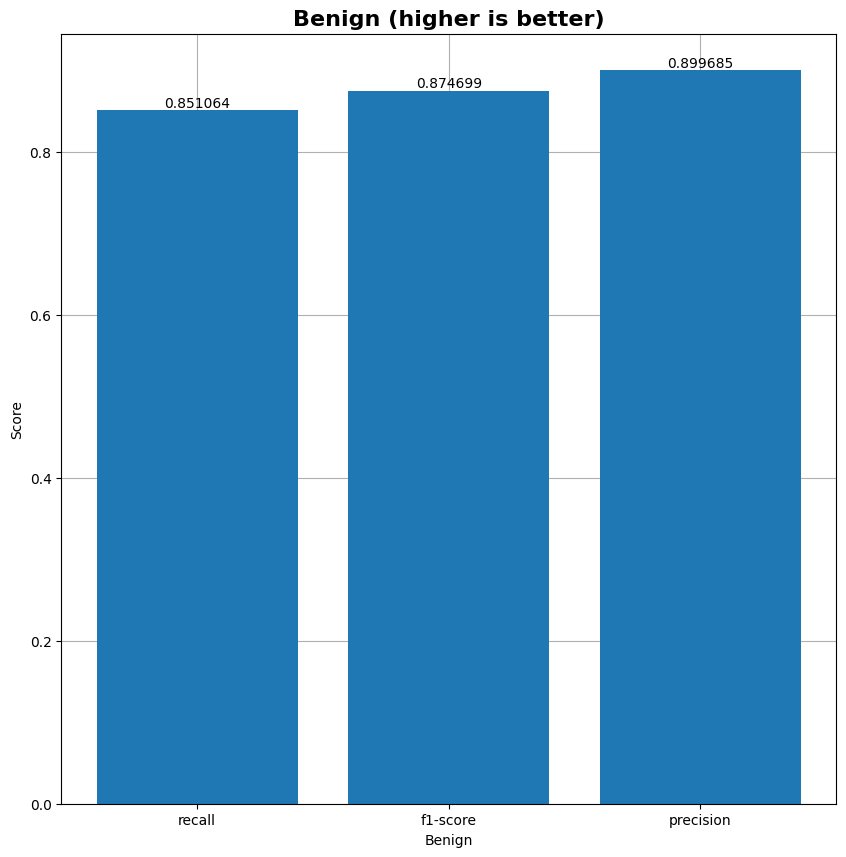

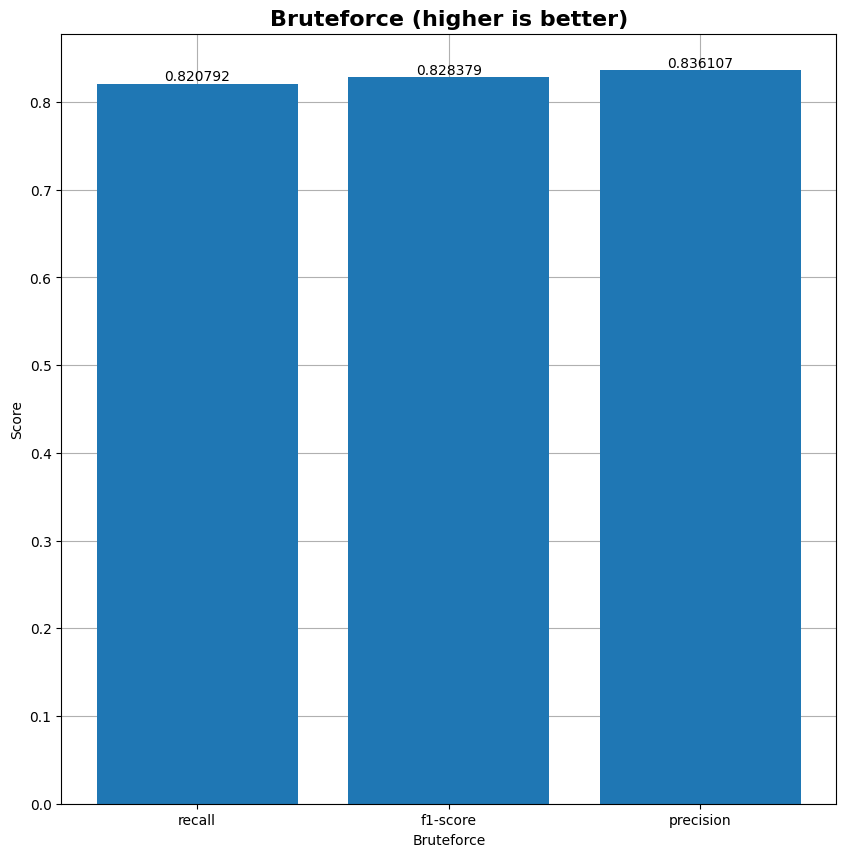

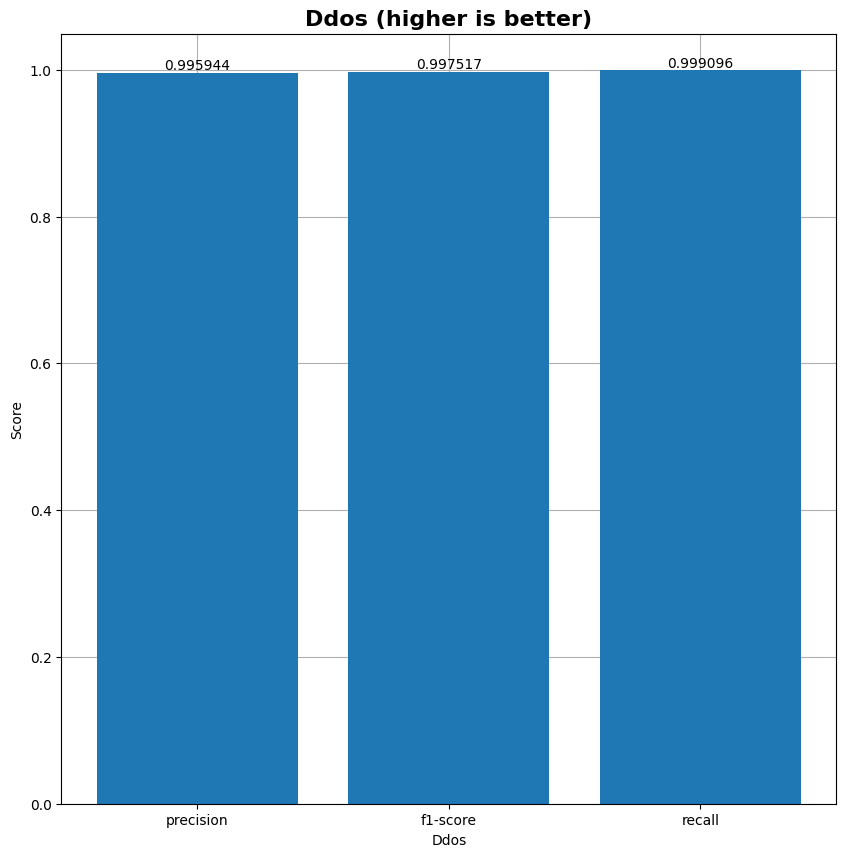

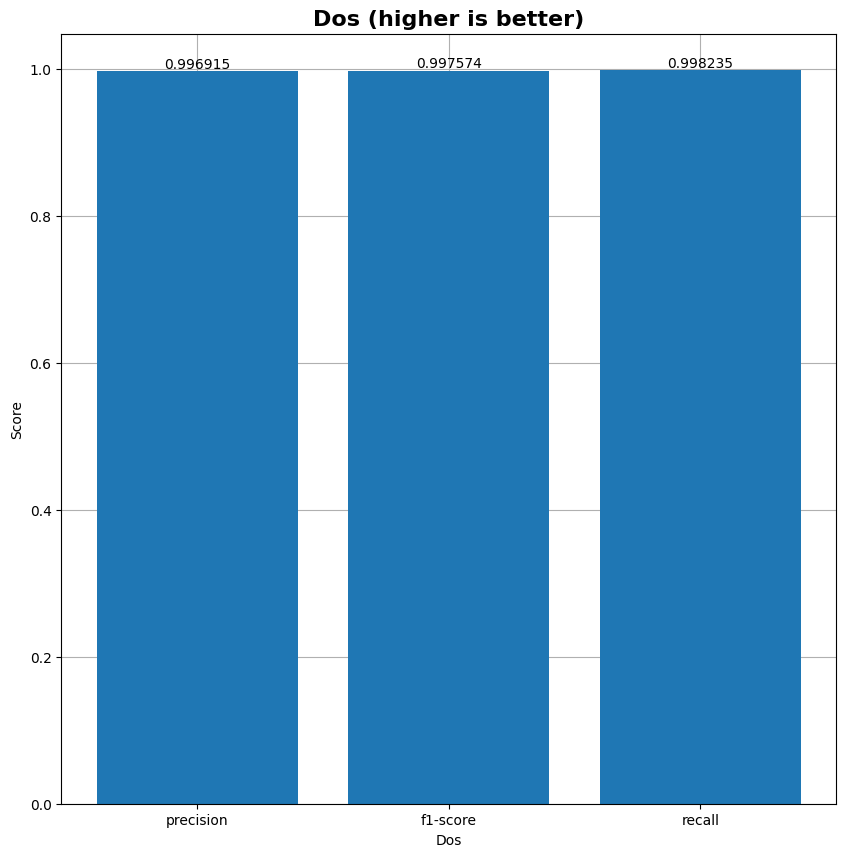

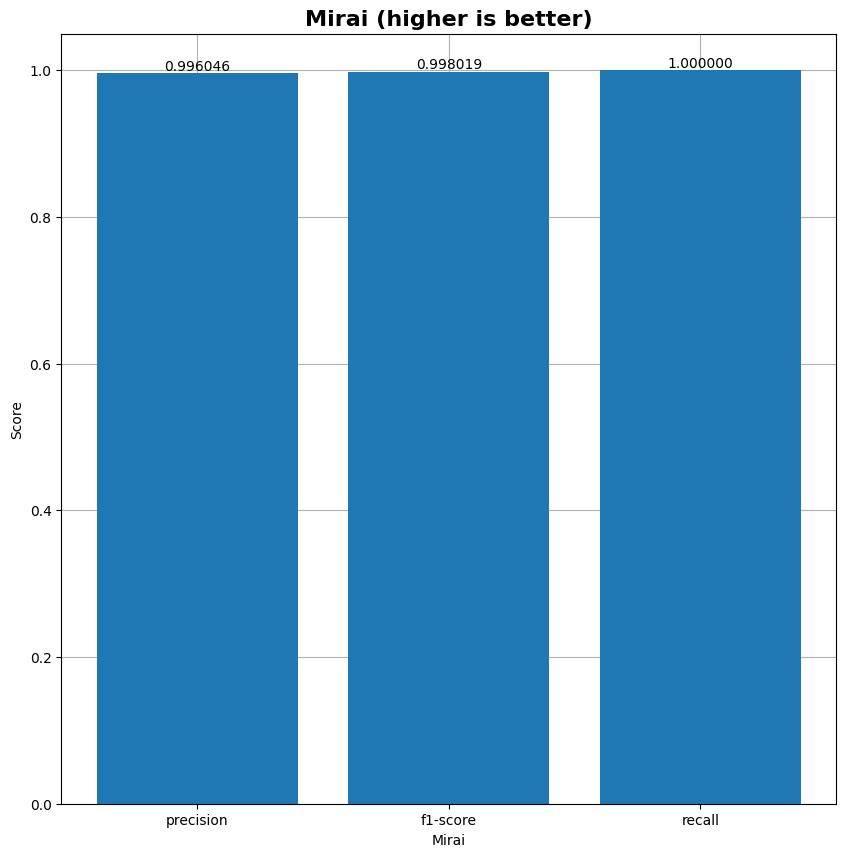

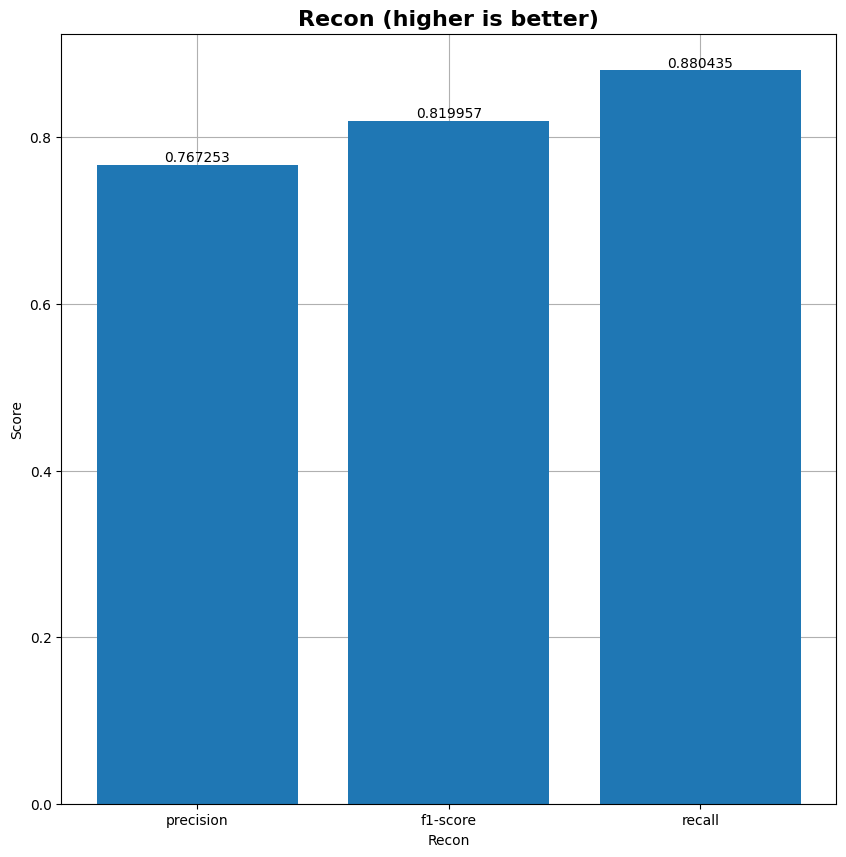

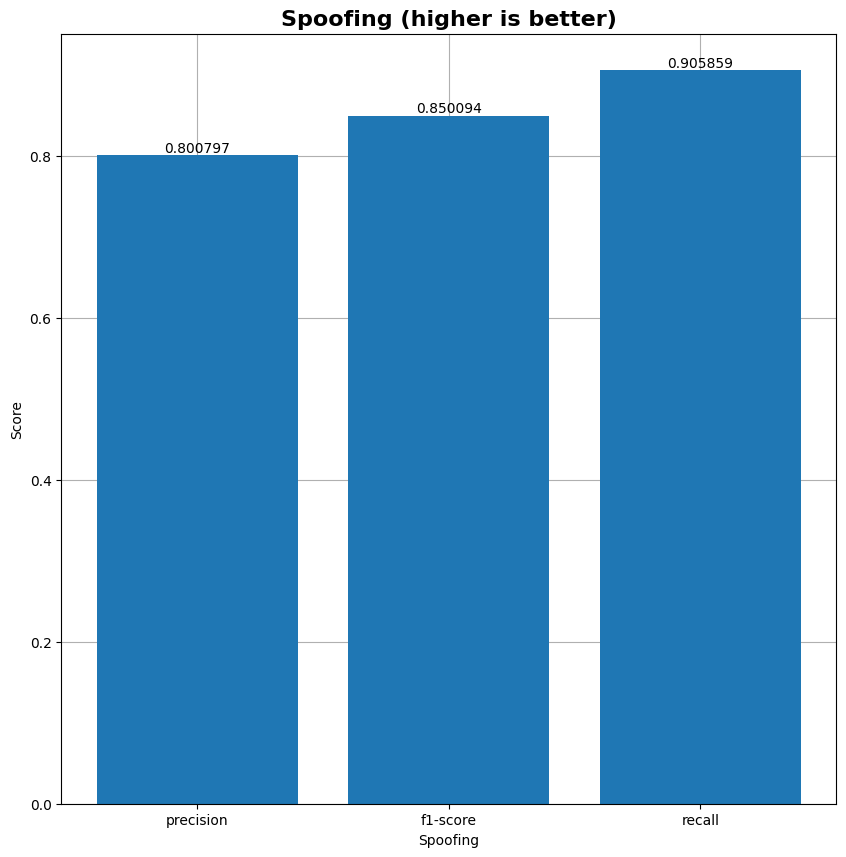

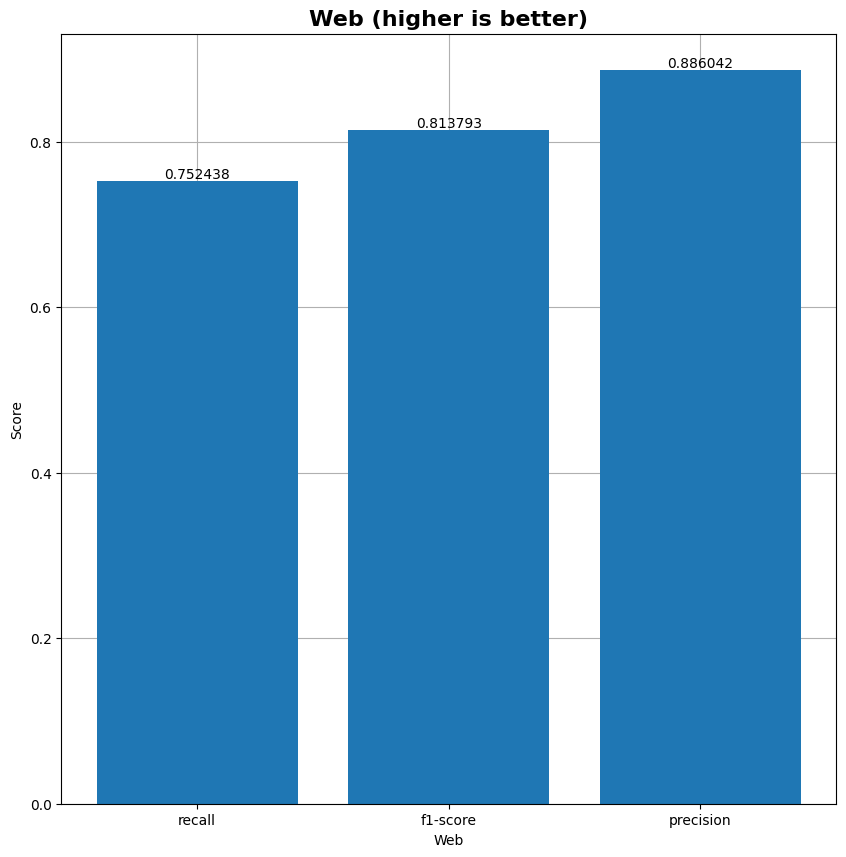

In [38]:
plot_mc(y_pred, y_test, "RF")

In [39]:
model_name = "RF_15000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [40]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 30.4 s, sys: 169 ms, total: 30.5 s
Wall time: 4.1 s


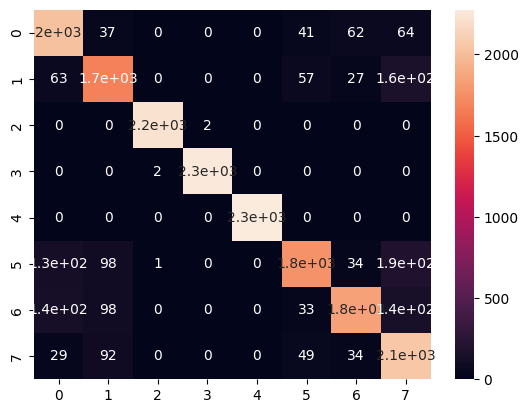

In [41]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [42]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [43]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [44]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [45]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.720045,0.726448,0.720738,0.720045,0.680853,1.057595,5.408470,2.325612,3.676489
LR,0.655618,0.667443,0.654224,0.655618,0.608307,1.197572,5.894692,2.427899,520.183744
RF,0.898532,0.902276,0.898715,0.898532,0.884540,0.385263,1.927442,1.388323,5.650334
XGBoost,0.910728,0.913899,0.910785,0.910728,0.898417,0.354489,1.804743,1.343407,4.102682


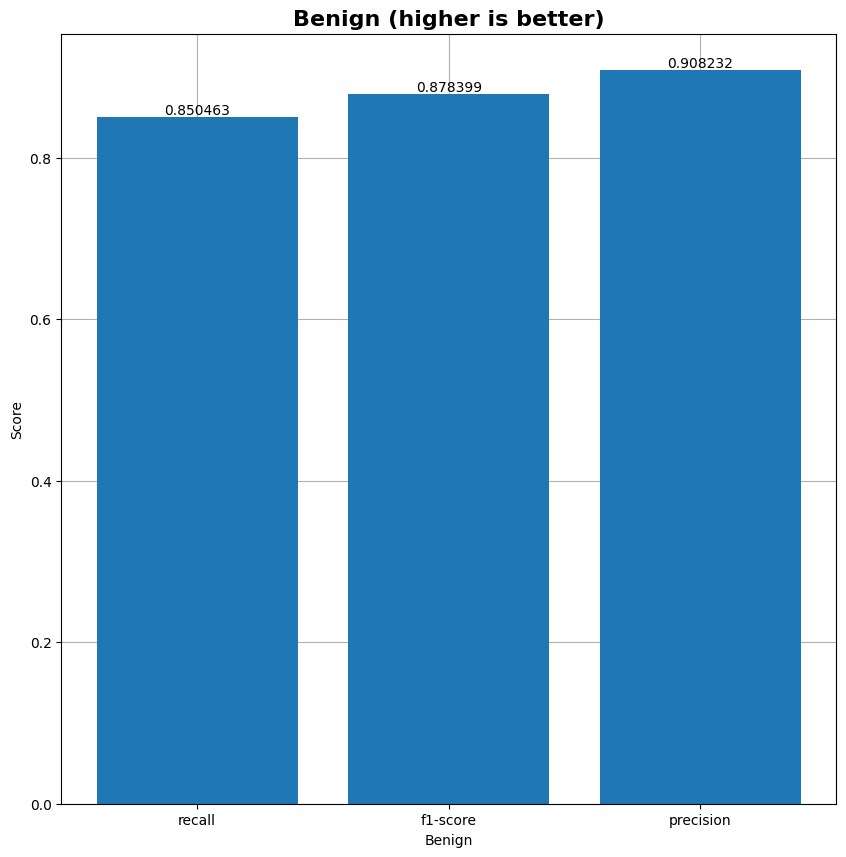

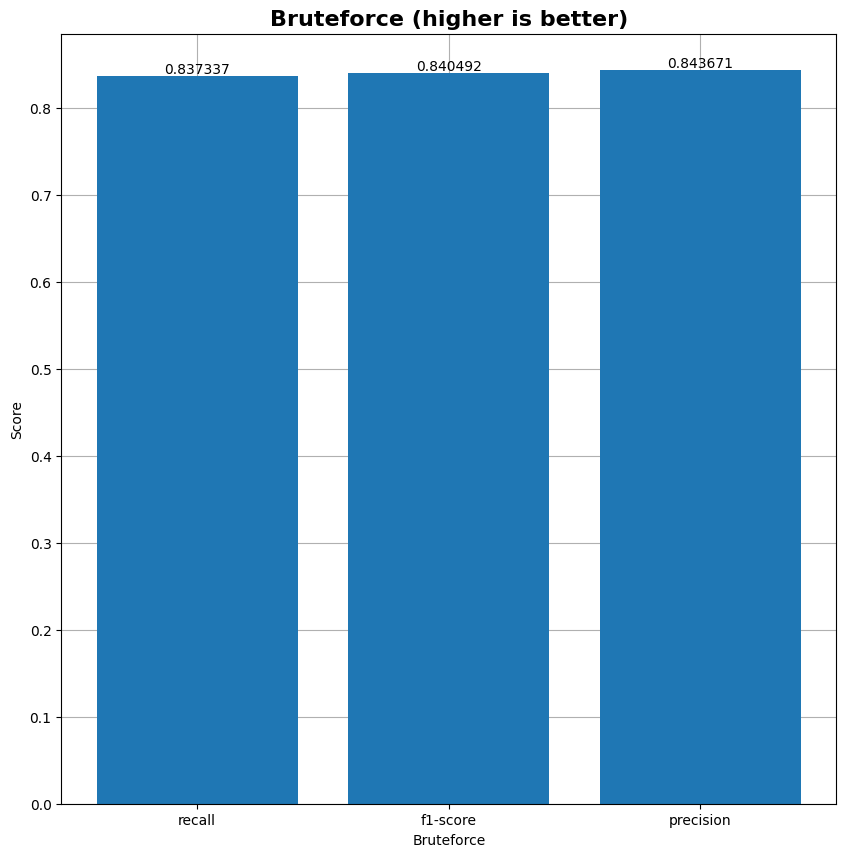

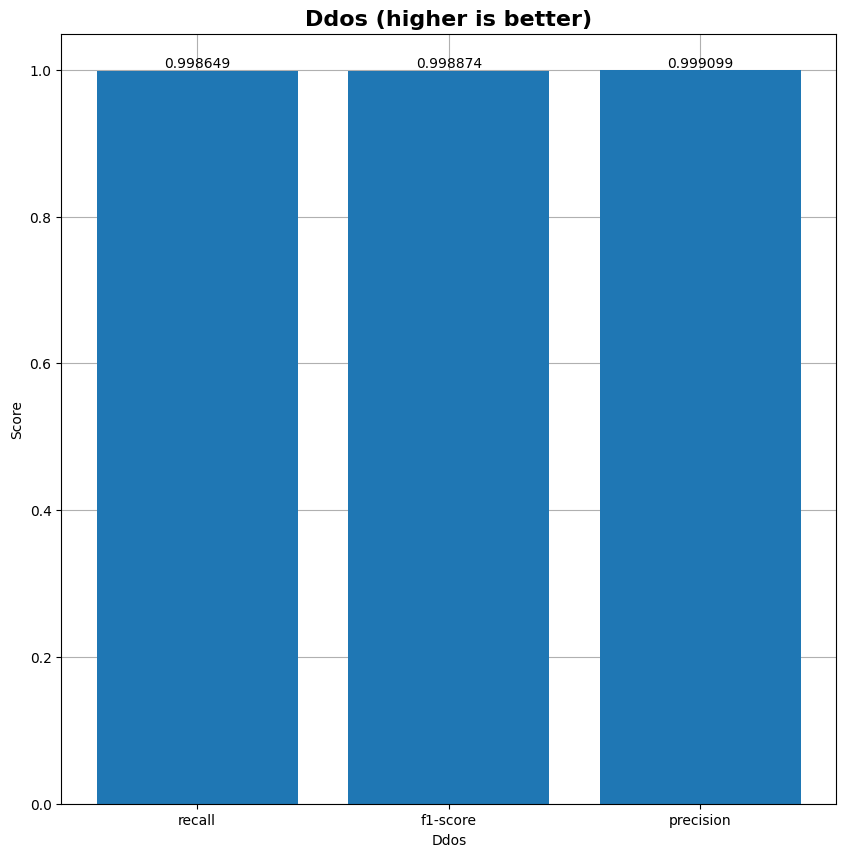

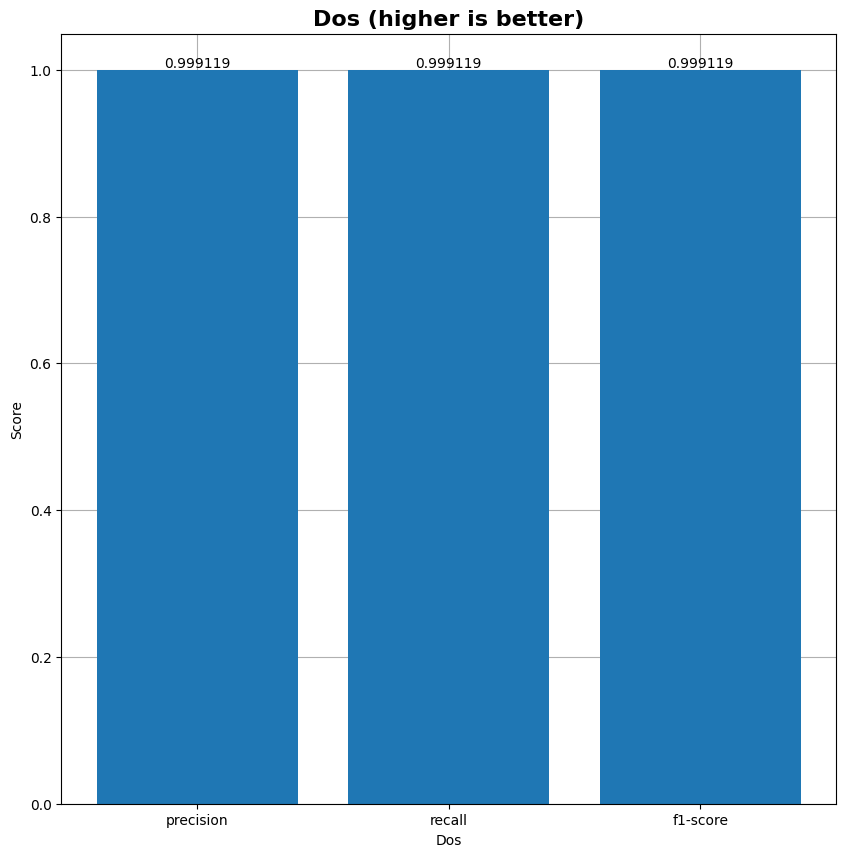

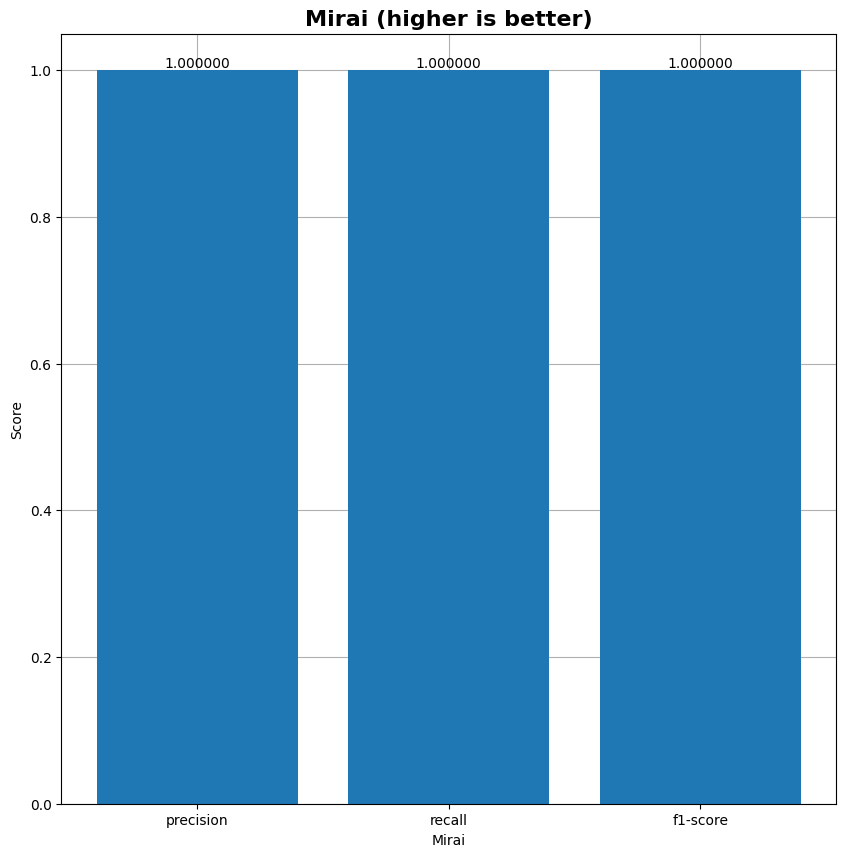

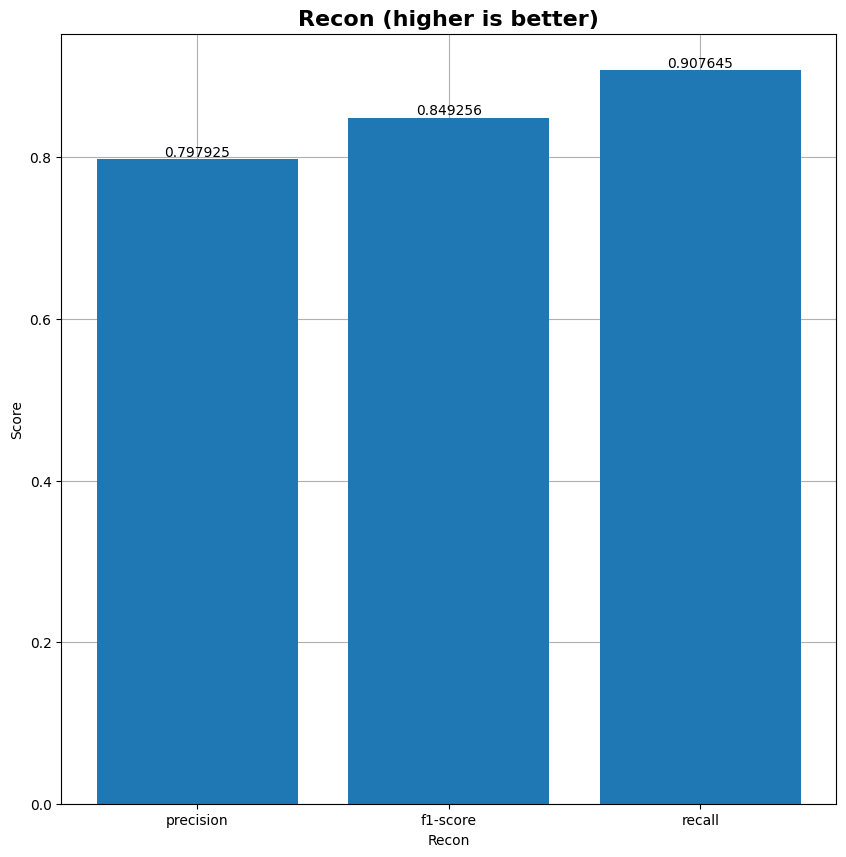

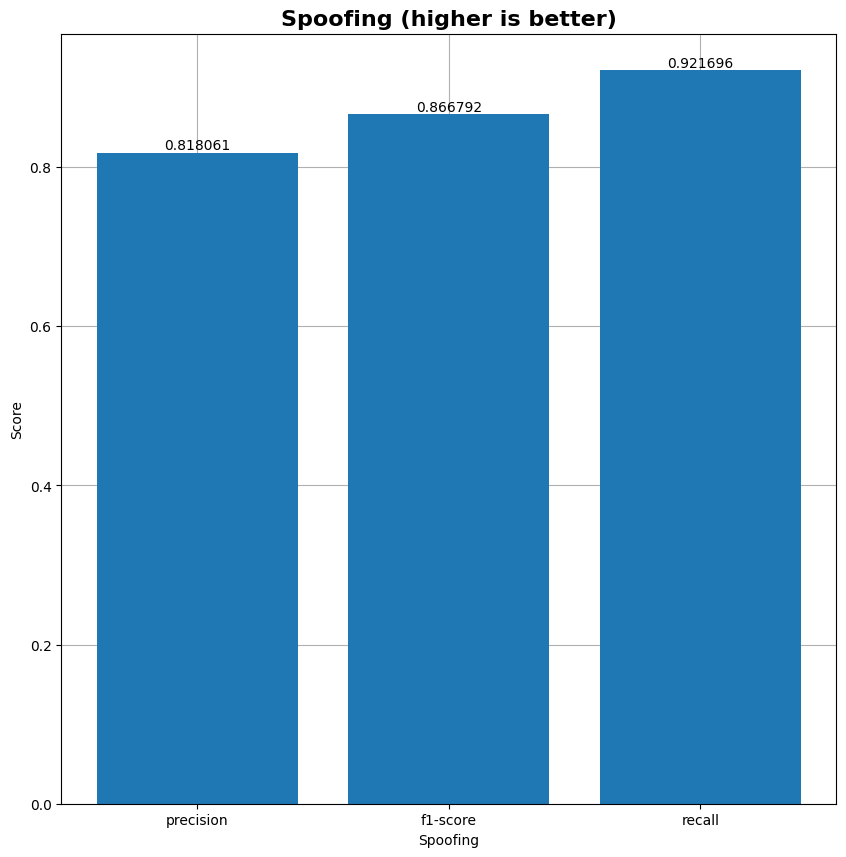

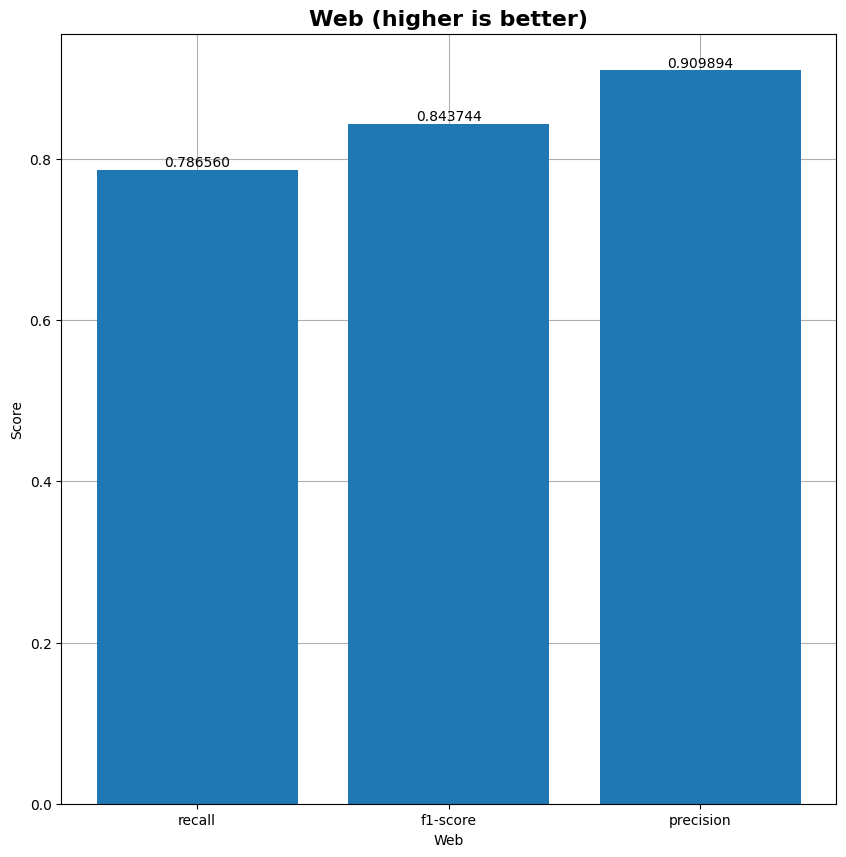

In [46]:
plot_mc(y_pred, y_test, "XGBoost")

In [47]:
model_name = "XGB_15000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [48]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5249
[LightGBM] [Info] Number of data points in the train set: 100354, number of used features: 39
[LightGBM] [Info] Start training from score -2.061057
[LightGBM] [Info] Start training from score -2.203472
[LightGBM] [Info] Start training from score -2.060744
[LightGBM] [Info] Start training from score -2.064664
[LightGBM] [Info] Start training from score -2.065214
[LightGBM] [Info] Start training from score -2.060588
[LightGBM] [Info] Start training from score -2.063879
[LightGBM] [Info] Start training from score -2.064271


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 13.8 s, sys: 95.3 ms, total: 13.9 s
Wall time: 3.58 s


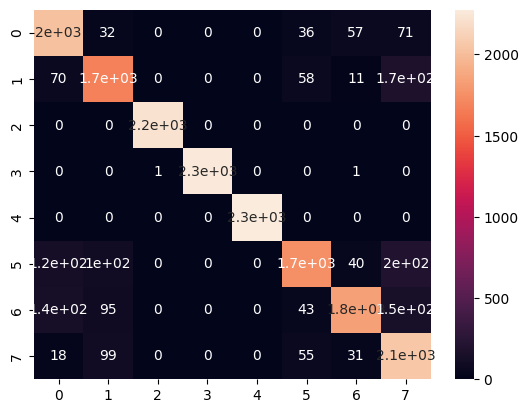

In [49]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [50]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [51]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [52]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [53]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.720045,0.726448,0.720738,0.720045,0.680853,1.057595,5.408470,2.325612,3.676489
LR,0.655618,0.667443,0.654224,0.655618,0.608307,1.197572,5.894692,2.427899,520.183744
RF,0.898532,0.902276,0.898715,0.898532,0.884540,0.385263,1.927442,1.388323,5.650334
XGBoost,0.910728,0.913899,0.910785,0.910728,0.898417,0.354489,1.804743,1.343407,4.102682
LightGBM,0.909317,0.912994,0.909375,0.909317,0.896883,0.354320,1.792603,1.338881,3.578276


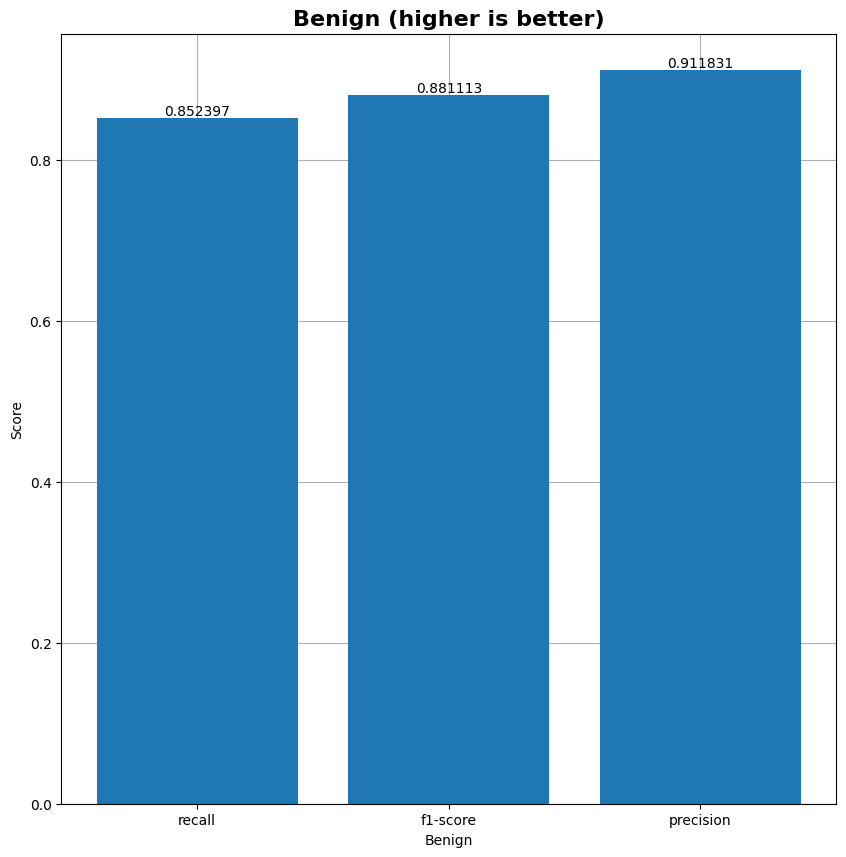

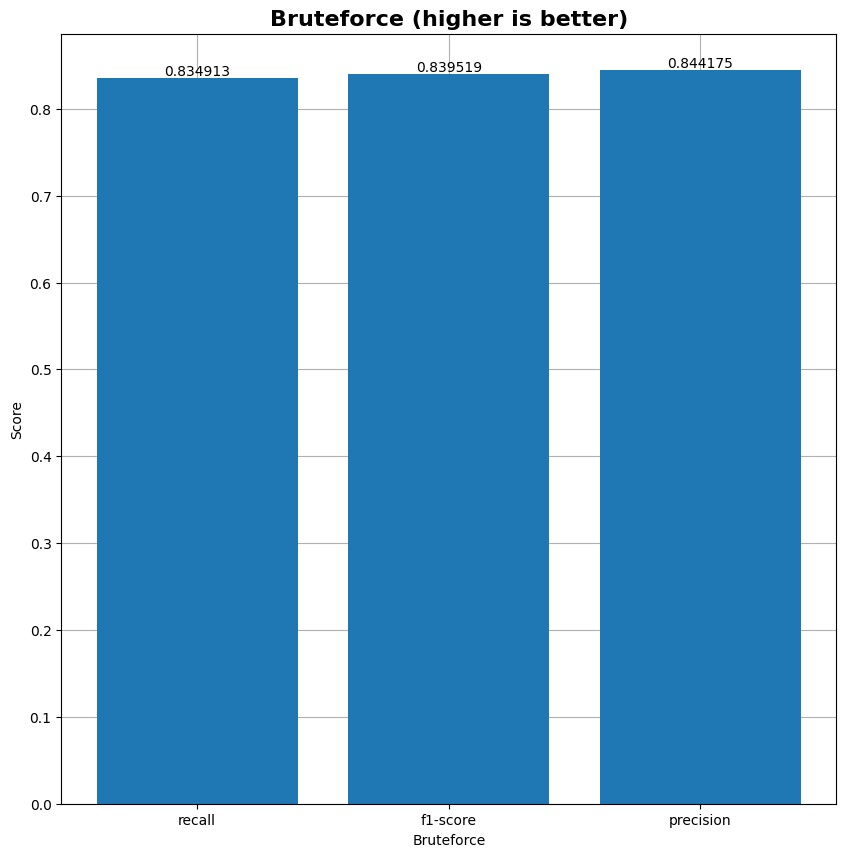

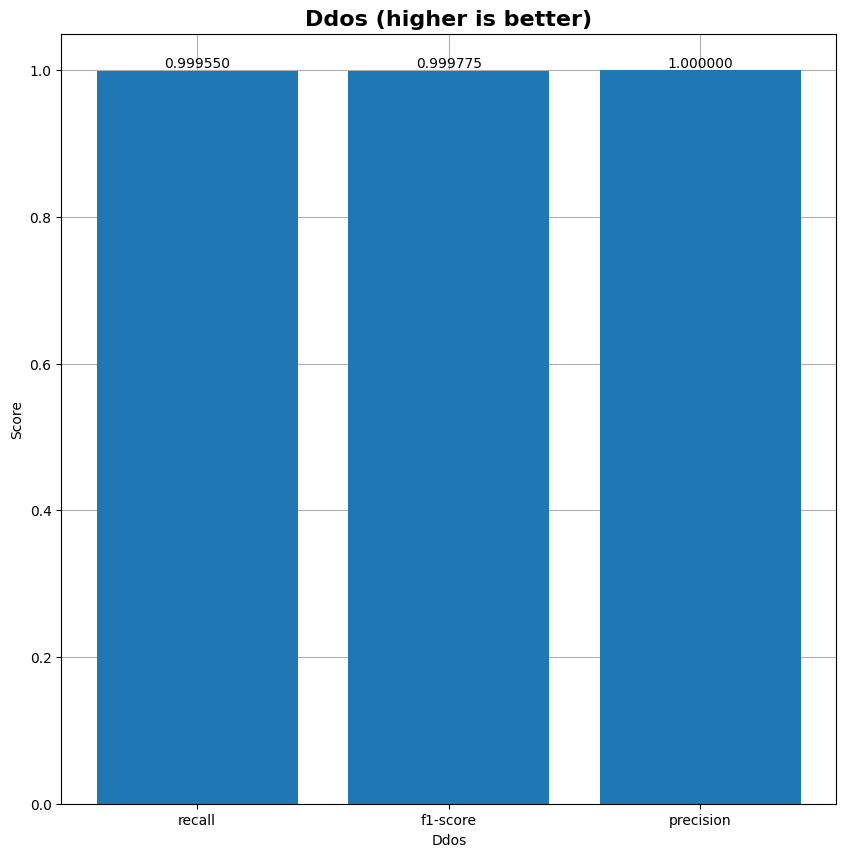

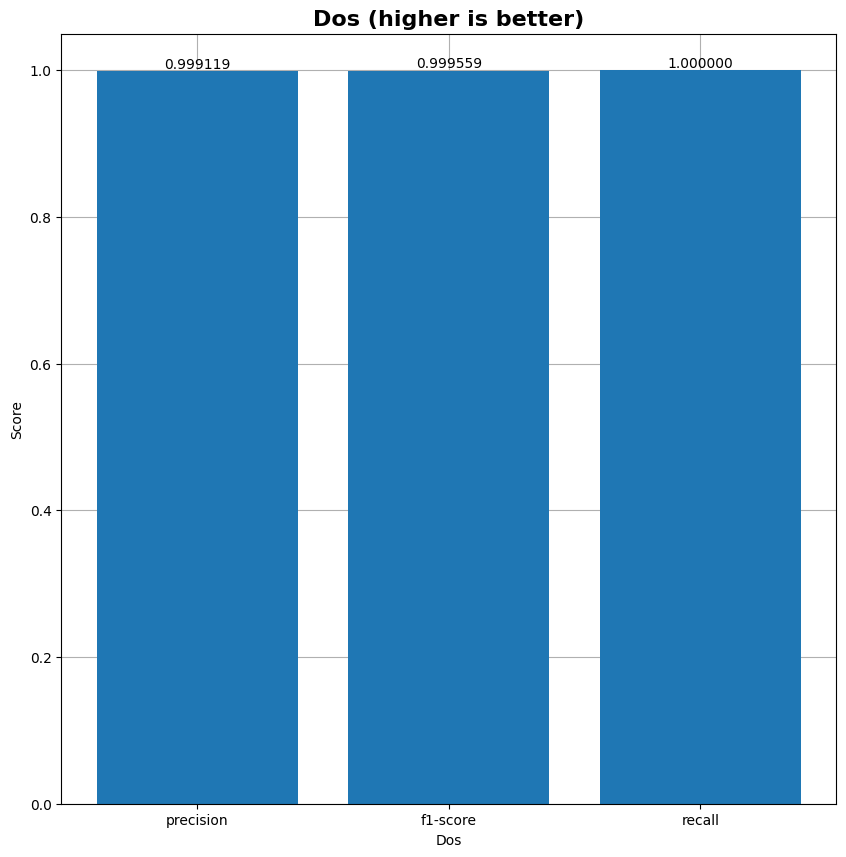

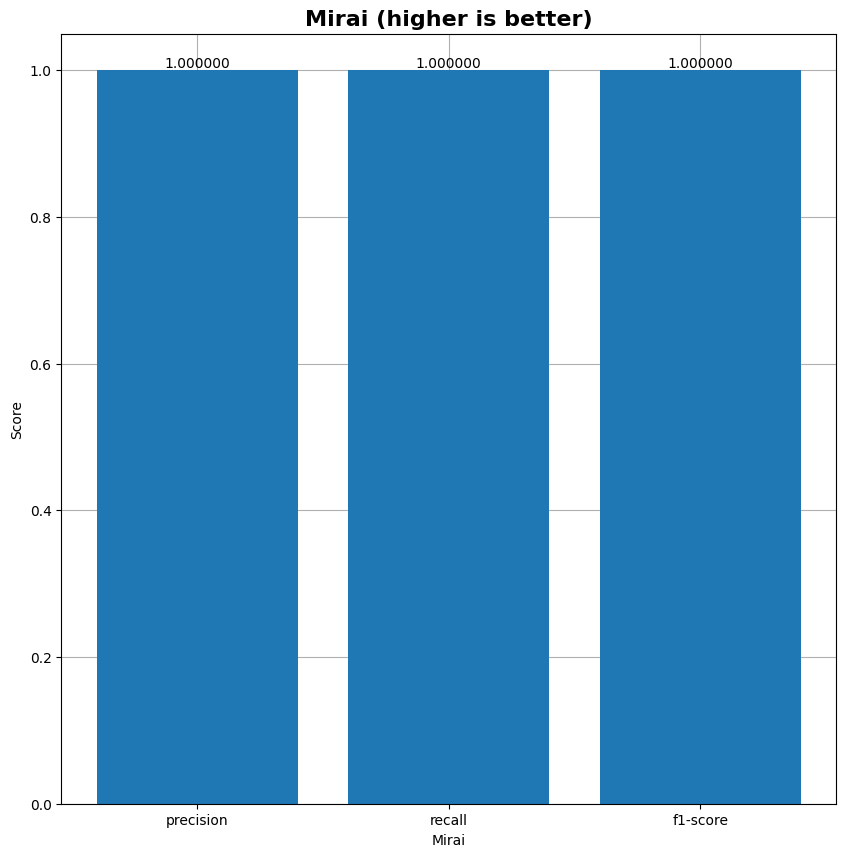

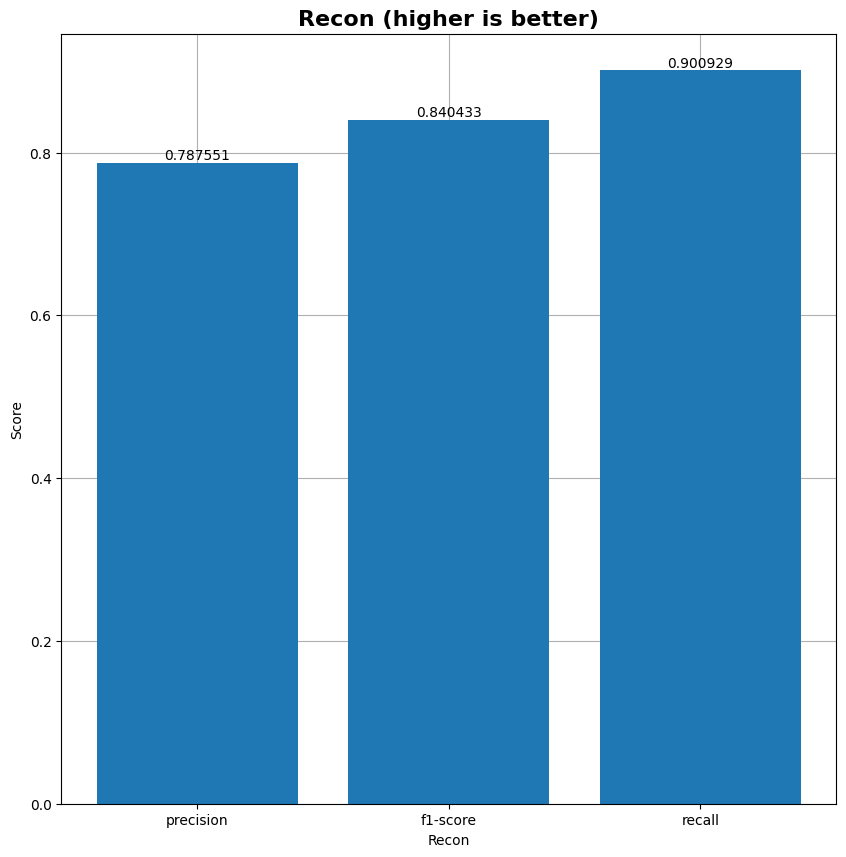

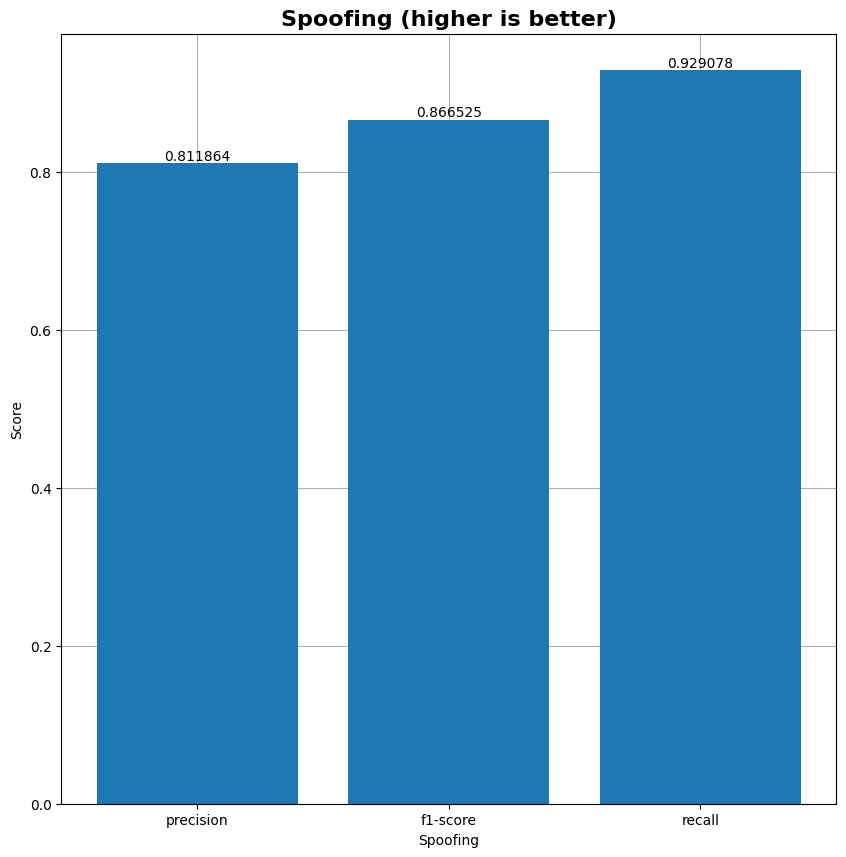

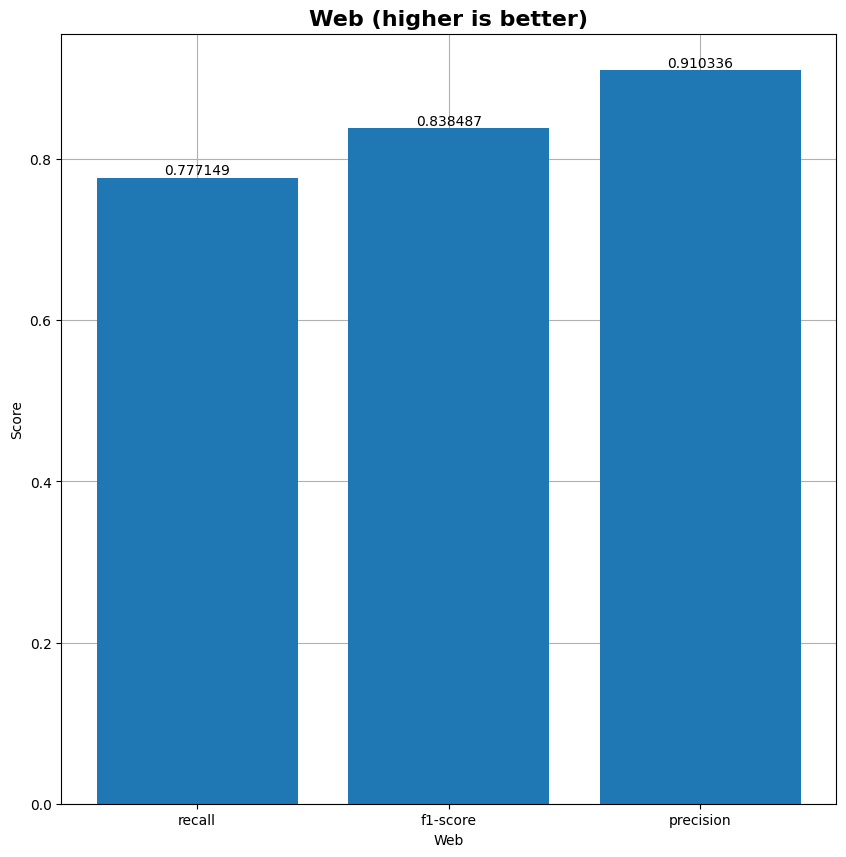

In [54]:
plot_mc(y_pred, y_test, "LightGBM")

In [55]:
model_name = "LightGBM_15000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Support Vector Machine

In [ ]:
%%time

start = time.time()

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

end = time.time()

SVM_Time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, SVM_Time]
results_dict["SVM"] = results

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "SVM")

In [ ]:
model_name = "SVM_15000.sav"
pickle.dump(svm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [ ]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

In [ ]:
model.summary()

In [ ]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "FF-NN")

In [ ]:
model_name = "FFNN_15000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [ ]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [ ]:
num_components = len(np.unique(y))

In [ ]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [ ]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

In [ ]:
model.summary()

In [ ]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)

In [ ]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "LSTM")

In [ ]:
model_name = "LSTM_15000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [ ]:
df_dict = results_df.to_dict()

In [ ]:
values = ['Precision', 'Recall', 'F1']
new_dict = {}
for value in values:
    new_dict[value] = df_dict[value]

In [ ]:
new_dict

In [ ]:
pd.DataFrame(new_dict).transpose()